<a href="https://colab.research.google.com/github/clashleyuncc/Intro-To-ML/blob/main/Final-Project/MLProjectFCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda

Energy Consumption by Day of the Week:
  Day_of_week  Usage_kWh
4    Thursday  175279.52
5     Tuesday  171862.65
1      Monday  168636.34
0      Friday  165709.51
6   Wednesday  161013.14
2    Saturday   79467.75
3      Sunday   37667.80
Target classes: ['Light_Load' 'Maximum_Load' 'Medium_Load']
4575
[3556, 254, 762, 3]
Esimated run time for 1000 Epoch: 0.314 minutes
0.019454002380371094 Seconds, Epoch 1, Training Loss 1.0994055271148682, Validation Loss 1.099123477935791
3.7589268684387207 Seconds, Epoch 500, Training Loss 1.008193016052246, Validation Loss 1.0100855827331543
15.11173677444458 Seconds, Epoch 1000, Training Loss 0.9848732948303223, Validation Loss 0.9872411489486694


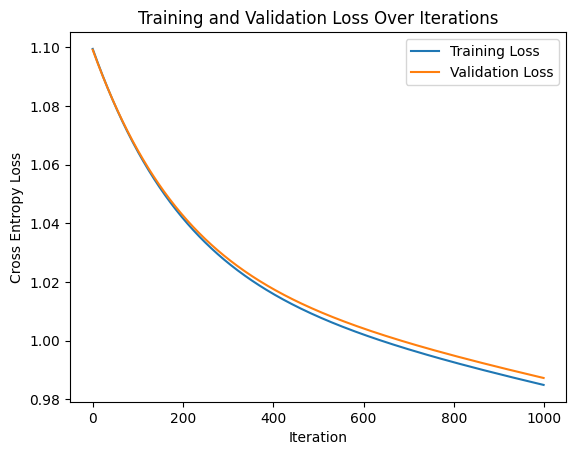

              precision    recall  f1-score   support

           0       0.71      0.95      0.81      3595
           1       0.52      0.75      0.61      1478
           2       0.53      0.02      0.04      1935

    accuracy                           0.65      7008
   macro avg       0.59      0.57      0.49      7008
weighted avg       0.62      0.65      0.56      7008



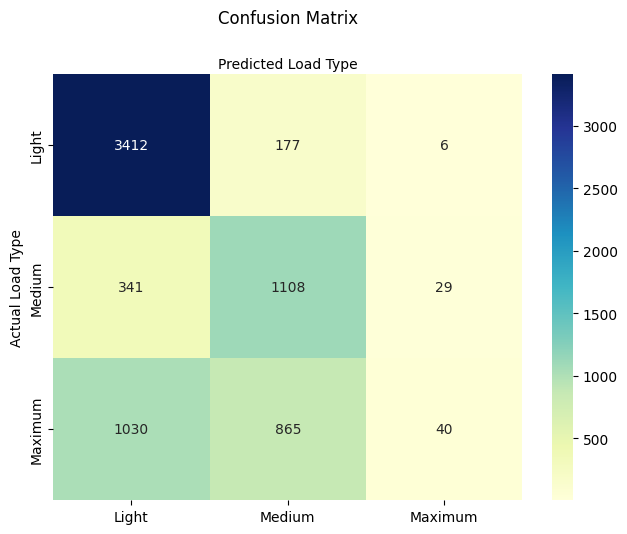

In [41]:

# Use of Logistic Regression to classify UC Irvine's
# "Steel Industry Energy Consumption" dataset into Light, Medium,
# and Maximum load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict
import time

#torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        t_u_train_device = t_u_train.to(device)
        t_c_train_device = t_c_train.to(device)

        t_p_train = model(t_u_train_device)
        loss_train = loss_fn(t_p_train, t_c_train_device)

        t_u_val_device = t_u_val.to(device)
        t_c_val_device = t_c_val.to(device)

        t_p_val = model(t_u_val_device)
        loss_val = loss_fn(t_p_val, t_c_val_device)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        train_losses.append(loss_train)
        val_losses.append(loss_val)

        if epoch == 1:
          print('Esimated run time for {} Epoch: {} minutes'.format(
                n_epochs, round((time.time()-start_time)*n_epochs/60,3)))
        if epoch == 1 or epoch % 500 == 0:
          print('{} Seconds, Epoch {}, Training Loss {}, Validation Loss {}'.format(
              time.time()-start_time, epoch, loss_train.item(), loss_val.item()))

!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)

y = steel_industry_energy_consumption.data.targets
X = steel_industry_energy_consumption.data.features

# Check for missing values and handle them
if X.isnull().sum().any():
    X = X.fillna(X.median())  # Replace missing values with median

# Analyze energy consumption by day of the week
if 'Day_of_week' in X.columns:
    energy_by_day = X.groupby('Day_of_week')['Usage_kWh'].sum().reset_index()
    energy_by_day = energy_by_day.sort_values(by='Usage_kWh', ascending=False)
    print("\nEnergy Consumption by Day of the Week:")
    print(energy_by_day)

# Encode categorical features if they exist
categorical_columns = ['WeekStatus', 'Day_of_week']
for col in categorical_columns:
    if col in X.columns:
        X = pd.get_dummies(X, columns=[col], drop_first=True, dtype='float')
# Identify and scale continuous features if they exist
continuous_columns = [
    'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM'
]
existing_continuous_columns = [col for col in continuous_columns if col in X.columns]
scaler = StandardScaler()
X[existing_continuous_columns] = scaler.fit_transform(X[existing_continuous_columns])

# Ensure y is a Series if it's a single-column DataFrame
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]  # Extract the first column as a Series

# Encode target variable if categorical
if y.dtype == 'object' or isinstance(y.iloc[0], str):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("Target classes:", label_encoder.classes_)

t_c = y
#t_u = X
t_c = torch.tensor(t_c)
t_u = torch.tensor(X.to_numpy())

t_u = t_u.to(torch.float32).to(device)
#t_c = t_c.to(torch.float32).to(device)
t_c = t_c.to(torch.long).to(device)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]
t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

train_losses = []
val_losses = []

seq_model = nn.Sequential(OrderedDict([
            ('hidden_linear1', nn.Linear(14, 254)),
            ('hidden_activation1', nn.Tanh()),
            #('hidden_linear2', nn.Linear(254, 8)),
            #('hidden_activation2', nn.Tanh()),
            ('output_linear', nn.Linear(254,3))
]))

numel_list = [p.numel() for p in seq_model.parameters()]
print(sum(numel_list))
print(numel_list)

seq_model.to(device)
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
start_time = time.time()

training_loop(
    n_epochs = 500,
    optimizer = optimizer,
    model = seq_model,
    #loss_fn = nn.MSELoss(),
    loss_fn = nn.CrossEntropyLoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

train_losses_cpu = torch.tensor(train_losses).cpu().numpy()
val_losses_cpu = torch.tensor(val_losses).cpu().numpy()

with torch.no_grad():
  plt.plot(train_losses_cpu, label="Training Loss")
  plt.plot(val_losses_cpu, label="Validation Loss")
  plt.xlabel("Iteration")
  #plt.ylabel("Mean Squared Error")
  plt.ylabel("Cross Entropy Loss")
  plt.legend()
  plt.title("Training and Validation Loss Over Iterations")
  plt.show()


seq_model.eval()

with torch.no_grad():
    t_u_val = t_u_val.to(device)
    predictions = seq_model(t_u_val)
    predicted_classes = torch.argmax(predictions, dim=1)

t_c_val = t_c_val.cpu().numpy()
predicted_classes = predicted_classes.cpu().numpy()

matrix = confusion_matrix(t_c_val, predicted_classes)
cnf_matrix = confusion_matrix(t_c_val, predicted_classes)
report = classification_report(t_c_val, predicted_classes)
print(report)

##

class_names=['Light','Medium','Maximum'] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g',
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Load Type')
plt.xlabel('Predicted Load Type')
plt.show()


In [ ]:
torch.cuda.empty_cache()

Using device: cuda
Target classes: ['Light_Load' 'Maximum_Load' 'Medium_Load']
4611
[3584, 256, 768, 3]
Esimated run time for 500 Epoch: 8.678 minutes
1.04155 Seconds, Epoch 1, Training Loss 1.1818950176239014, Validation Loss 1.1707804203033447
102.85485 Seconds, Epoch 100, Training Loss 0.6463663578033447, Validation Loss 0.6275007724761963
206.36622 Seconds, Epoch 200, Training Loss 0.61658775806427, Validation Loss 0.5835992693901062
305.27578 Seconds, Epoch 300, Training Loss 0.6408965587615967, Validation Loss 0.5660440325737
416.74914 Seconds, Epoch 400, Training Loss 0.5607994794845581, Validation Loss 0.555075466632843
512.78842 Seconds, Epoch 500, Training Loss 0.5423176288604736, Validation Loss 0.5468620657920837


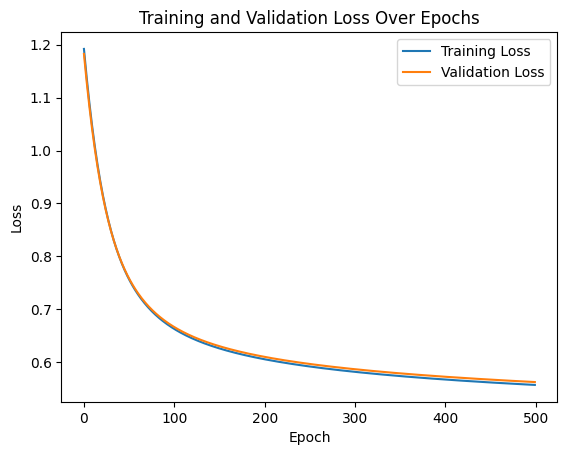

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3622
           1       0.57      0.63      0.60      1455
           2       0.61      0.58      0.60      1931

    accuracy                           0.74      7008
   macro avg       0.69      0.69      0.69      7008
weighted avg       0.74      0.74      0.74      7008



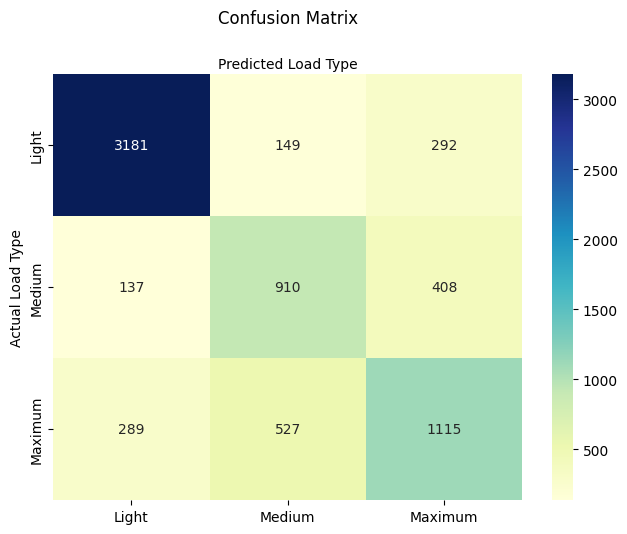

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import time
from torch.utils.data import DataLoader, TensorDataset

# Check device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and prepare the data (this part stays the same as your existing code)

!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

# Fetch dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)

y = steel_industry_energy_consumption.data.targets
X = steel_industry_energy_consumption.data.features

# Check for missing values and handle them
if X.isnull().sum().any():
    X = X.fillna(X.median())  # Replace missing values with median

# Encode categorical features if they exist
categorical_columns = ['WeekStatus', 'Day_of_week']
for col in categorical_columns:
    if col in X.columns:
        X = pd.get_dummies(X, columns=[col], drop_first=True, dtype='float')

# Identify and scale continuous features if they exist
continuous_columns = [
    'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM'
]
existing_continuous_columns = [col for col in continuous_columns if col in X.columns]
scaler = StandardScaler()
X[existing_continuous_columns] = scaler.fit_transform(X[existing_continuous_columns])

# Ensure y is a Series if it's a single-column DataFrame
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]  # Extract the first column as a Series

# Encode target variable if categorical
if y.dtype == 'object' or isinstance(y.iloc[0], str):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("Target classes:", label_encoder.classes_)

# Convert data to tensors and send to device
t_c = torch.tensor(y).to(device)
t_u = torch.tensor(X.to_numpy()).to(torch.float32).to(device)

# Split data into training and validation sets
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
t_u_train = t_u[train_indices].to(device)
t_c_train = t_c[train_indices].to(device)
t_u_val = t_u[val_indices].to(device)
t_c_val = t_c[val_indices].to(device)

# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(t_u_train, t_c_train)
val_dataset = TensorDataset(t_u_val, t_c_val)

# Create DataLoaders for both training and validation sets
batch_size = 64  # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

# Define the model
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear1', nn.Linear(14, 256)),
    ('hidden_activation1', nn.Tanh()),
    ('output_linear', nn.Linear(256, 3))
]))

numel_list = [p.numel() for p in seq_model.parameters()]
print(sum(numel_list))
print(numel_list)

seq_model = seq_model.to(device)  # Send model to device

# Set up the optimizer
optimizer = optim.SGD(seq_model.parameters(), lr=1e-5)

# Function to train and evaluate the model with mini-batches
def training_loop(n_epochs, optimizer, seq_model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        seq_model.train()  # Set the model to training mode
        total_train_loss = 0  # To track the training loss
        for batch_idx, (t_u_batch, t_c_batch) in enumerate(train_loader):
            t_u_batch, t_c_batch = t_u_batch.to(device), t_c_batch.to(device)
            optimizer.zero_grad()
            t_p_batch = seq_model(t_u_batch)

            loss_train = loss_fn(t_p_batch, t_c_batch)
            total_train_loss += loss_train.item()

            loss_train.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)

        seq_model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for t_u_batch, t_c_batch in val_loader:
                t_u_batch, t_c_batch = t_u_batch.to(device), t_c_batch.to(device)

                t_p_batch = seq_model(t_u_batch)
                loss_val = loss_fn(t_p_batch, t_c_batch)
                total_val_loss += loss_val.item()

        avg_val_loss = total_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if epoch == 1:
          print('Esimated run time for {} Epoch: {} minutes'.format(
                n_epochs, round((time.time()-start_time)*n_epochs/60,3)))
        if epoch == 1 or epoch % 200 == 0:
          print('{} Seconds, Epoch {}, Training Loss {}, Validation Loss {}'.format(
              round(time.time()-start_time,5), epoch, loss_train.item(), loss_val.item()))

start_time = time.time()

training_loop(
    n_epochs=1000,
    optimizer=optimizer,
    seq_model=seq_model,
    loss_fn=nn.CrossEntropyLoss(),
    train_loader=train_loader,
    val_loader=val_loader
)

# Plot training and validation loss
train_losses_cpu = torch.tensor(train_losses).cpu().numpy()
val_losses_cpu = torch.tensor(val_losses).cpu().numpy()

with torch.no_grad():
    plt.plot(train_losses_cpu, label="Training Loss")
    plt.plot(val_losses_cpu, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.show()

seq_model.eval()

with torch.no_grad():
    t_u_val = t_u_val.to(device)
    predictions = seq_model(t_u_val)
    predicted_classes = torch.argmax(predictions, dim=1)

t_c_val = t_c_val.cpu().numpy()
predicted_classes = predicted_classes.cpu().numpy()

# Confusion Matrix
matrix = confusion_matrix(t_c_val, predicted_classes)
report = classification_report(t_c_val, predicted_classes)
print(report)

# Plot Confusion Matrix
class_names = ['Light', 'Medium', 'Maximum']  # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# Create heatmap
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu", fmt='g',
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Load Type')
plt.xlabel('Predicted Load Type')
plt.show()
